# Исследование юнит-экономики однопользовательской мобильной игры

За последний год мобильная игра успешно развивалась, привлекая новых пользователей. Метрики продукта в целом стабильны и не вызывают опасений.
Однако для развития приложению постоянно требуются новые источники трафика, поэтому требуется проанализировать экономику текущих способов привлечения и приготовить экспертное заключение.  

Пользователи приходят в продукт тремя способами: 
* прямое скачивание (органические пользователи);
* реклама в Google, Yandex, VK и партнёрских сетях;
* реферальные программы.

**Задача:**  
- Провести расчёт и анализ ключевых метрик: LTV, CAC, ROI, ARPPU и Retention Rate
- Составить заключение о текущем состоянии юнит-экономики приложения.

**План работы:**  
1. Подготовка данных.
2. Когортный анализ LTV.
3. Расчёт CAC.
4. Расчёт Payback Period.
5. Расчёт ROI.
6. Расчёт ARPPU и Retention Rate.
7. Заключение о текущем состоянии юнит-экономики

**Описание данных:**  

**Таблица `users.csv` — информация о пользователях.**
- `device_id` — уникальный идентификатор устройства.
- `install_time` — дата и время установки игры.
- `country_code` — код страны.
- `traffic_type` — тип трафика.
- `platform` — ОС устройства.
- `source` — источник привлечения.
- `campaign` — название рекламной кампании.
- `user_id` — уникальный идентификатор пользователя.
  
**таблица `events.csv` — события пользователей в игре.**
- `device_id` — идентификатор устройства.
- `session_id` — идентификатор сессии.
- `time` — дата и время события.
- `event_name` — событие запуска игры.

**Таблица `transactions.csv` — данные о транзакциях пользователей.**
- `device_id` — уникальный идентификатор устройства.
- `session_id` — идентификатор игровой сессии.
- `transaction_id` — уникальный идентификатор транзакции.
- `time` — дата и время покупки.
- `payment_type` — способ оплаты.
- `item_name` — название товара.
- `price` — стоимость товара.
- `status` — статус транзакции.

**Таблица `costs.csv` — затраты на маркетинг по месяцам и каналам.**
- `month` — месяц в формате YYYY-MM.
- `source` — рекламный источник.
- `traffic_type` — тип трафика.
- `marketing_costs` — затраты на маркетинг.

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
path_users = 'https://drive.google.com/uc?export=download&id=12Xi0NEqppiKvVliekm0c6qzAfdwmh9yc'
path_events = 'https://drive.google.com/uc?export=download&id=1jFRO53bcFKa4qYeXk7Z6xS7EaRaTZz3T'
path_transactions = 'https://drive.google.com/uc?export=download&id=1zjwFYzAkv7paZxVkC1BIDocgloaciNFl'
path_marketing = 'https://drive.google.com/uc?export=download&id=1t9IUPfpEUlaxDo49nK9-eY0Ycg5_nO2Q'

# Создаём датафреймы
df_users = pd.read_csv(path_users)
df_events = pd.read_csv(path_events)
df_transactions = pd.read_csv(path_transactions)
df_marketing_costs = pd.read_csv(path_marketing)

In [3]:
# Настройки отображения DataFrame
pd.set_option('display.max_columns', None)  # Отображать все столбцы
pd.set_option('display.expand_frame_repr', False)  # Отключить перенос строк

In [4]:
df_users.head()

,device_id,install_time,country_code,traffic_type,platform,source,campaign,user_id
0,bd8faa44-01d5-4fac-8e58-102ef16d72b6,2024-01-23 13:09:52,AZ,paid,ios,youtube,yt2,1.0
1,788cdde7-aa57-41f1-ac42-402ed9fa1b47,2024-01-05 18:21:35,RU,organic,ios,direct_app_download,NaN,3.0
2,f1842785-15e9-4fda-9b2d-5ffdcceae78b,2024-01-02 10:42:57,RU,paid,android,google,g2,4.0
3,26f430d8-841c-4944-9f6d-2262a1d64787,2024-01-02 21:59:31,RU,organic,ios,direct_app_download,NaN,5.0
4,ace4f666-c8ac-45b7-a0c1-e9f3dad48ab1,2024-01-21 19:29:42,BY,organic,ios,direct_app_download,NaN,NaN


In [5]:
df_events.head()

,device_id,session_id,time,event_name
0,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,1,2024-01-01,app_start
1,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,2,2024-01-02,app_start
2,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,3,2024-01-02,app_start
3,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,4,2024-01-04,app_start
4,ebd6c0a6-5a0a-4ea4-8f36-48771c983b1a,5,2024-01-04,app_start


In [6]:
df_transactions.head()

,device_id,session_id,transaction_id,time,payment_type,item_name,price,status
0,0000614f-d87f-4b5b-a082-d86e72c22696,14,210588,2024-08-25 18:19:08,paypal,chest_1,22,failed
1,0000614f-d87f-4b5b-a082-d86e72c22696,30,160059,2024-12-19 04:59:01,bank_card,coin_pack_2,25,success
2,002250f4-c829-4760-af70-b53d75986d2d,15,630387,2024-09-29 18:12:37,bank_card,chest_1,22,success
3,002250f4-c829-4760-af70-b53d75986d2d,31,874370,2024-10-26 13:55:40,game_wallet,chest_1,22,success
4,002250f4-c829-4760-af70-b53d75986d2d,33,623694,2024-11-02 01:55:05,bank_card,skin_bundle_1,14,success


In [7]:
df_marketing_costs.head()

,month,source,traffic_type,marketing_costs
0,2024-01,google,paid,8269
1,2024-01,telegram,paid,6230
2,2024-01,partners_websites,paid,6876
3,2024-01,ref,referral,4363
4,2024-01,vk,paid,5085


## Подготовка данных

- **Агрегируем данные датафрейма с событиями пользователей `df_events`**, чтобы получить для каждого устройства его первый месяц активности, каждый месяц активности и количество сессий за месяц. Это позволит посчитать `N_period` и определить к какой когорте относится пользователь. Результат запишем в `df_monthly_events`

In [8]:
# Преобразуем время события в формат месяца Period[M] для анализа данных по месяцам
df_events['activity_month'] = pd.to_datetime(df_events['time']).dt.to_period('M')

# Определяем первый месяц активности для каждого устройства  
df_events['first_activity_month'] = df_events.groupby('device_id')['activity_month'].transform('min')

# Группируем по устройству, месяцу, первому месяцу активности и подсчитываем сессии
df_monthly_events = df_events.groupby(['device_id', 'activity_month', 'first_activity_month'])['session_id'].count().reset_index(name='count_sessions')
df_monthly_events.head()

,device_id,activity_month,first_activity_month,count_sessions
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4
3,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10


Данные о действиях пользователей агрегированы до месяца. Это позволит выполнить более глубокий анализ жизненного цикла клиентов и рассчитать метрики юнит-экономики.

- **Агрегируем данные из датафрейма с транзакциями `df_transactions`**, чтобы получить данные о выручке за месяц  по каждому устройству и месяцу активности. ПРи этом учитывать будем только успешные транзакции, то есть `status = 'success'`. Данные запишем в  датафрейм `df_monthly_transactions`

In [9]:
# Преобразование колонки 'time' в формат Period[M] для анализа данных на месячном уровне
df_transactions['activity_month'] = pd.to_datetime(df_transactions['time']).dt.to_period('M')

# Фильтрация успешных транзакций — это исключает отменённые/незавершённые платежи
df_successful_transactions = df_transactions[df_transactions['status'] == 'success']

# Группировка данных по устройству и месяцу с расчётом общей выручки пользователей за каждый месяц
# Для колонки с суммарной выручкой сразу устанавливаем название total_revenue
df_monthly_transactions = df_successful_transactions.groupby(['device_id', 'activity_month'])['price'].sum().reset_index(name='total_revenue')

df_monthly_transactions.head()

,device_id,activity_month,total_revenue
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,25
1,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,64
2,00010045-a5c6-4428-a40e-543f6a00c779,2024-12,66
3,002250f4-c829-4760-af70-b53d75986d2d,2024-09,22
4,002250f4-c829-4760-af70-b53d75986d2d,2024-10,22


Данные о транзакциях по месяцам на каждого пользователя готовы. Теперь у нас есть данные об активности игроков и их фактической монетизации в разрезе каждого месяца.

- **Создадим датафрей `df_monthly`** с данными об активности и монетизации пользователей, по которому будем проводить анализ

In [10]:
# Объединяем данные о событиях и транзакциях по device_id и месяцу активности
df_monthly_events_transactions = df_monthly_events.merge(
    df_monthly_transactions,
    on=['device_id', 'activity_month'],
    how='left'
)  
df_monthly_events_transactions.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,NaN
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,NaN
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,NaN
3,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18,25.0
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,NaN


In [11]:
# Пропущенные значения в поле total_revenue заменяем на 0
df_monthly_events_transactions['total_revenue'] = df_monthly_events_transactions['total_revenue'].fillna(0)

In [12]:
# Объединяем данные о событиях и транзакциях с атрибутами пользователей из таблицы df_users
df_monthly = pd.merge(
    df_monthly_events_transactions,
    df_users[['device_id','traffic_type','source']],
    on='device_id',
    how='left'
)
df_monthly.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue,traffic_type,source
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google
3,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18,25.0,paid,google
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok


In [13]:
# Рассчитываем, сколько месяцев прошло с первого месяца активности пользователя до текущего месяца, результат запишем в n_period
df_monthly['n_period'] = df_monthly['activity_month'].dt.month- df_monthly['first_activity_month'].dt.month
df_monthly.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue,traffic_type,source,n_period
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google,0
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4
3,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18,25.0,paid,google,5
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok,0


In [14]:
# Удаляем данные за последний доступный месяц, так как они могут быть неполными
df_monthly = df_monthly[df_monthly['activity_month'] < df_monthly['activity_month'].max()]

В результате подготовительной работы объеденены и агрегированы данные о событиях, транзакциях и источниках привлечения. Рассчитаны ключевые метрики: первый месяц активности, помесячная выручка, каналы привлечения. 

## Когортный анализ LTV

- **Рассчитаем накопленный Lifetime Value (LTV) пользователей**

In [15]:
# Сортируем значения для корректного расчёта кумулятивной суммы
df_monthly.sort_values(by=['device_id', 'n_period'], inplace=True)

# Рассчитываем LTV как кумулятивную сумму выручки одного пользователя
df_monthly['LTV'] = df_monthly.groupby(['device_id'])['total_revenue'].cumsum()

In [16]:
df_monthly.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue,traffic_type,source,n_period,LTV
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google,0,0.0
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1,0.0
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4,0.0
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok,0,0.0
5,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,2024-09,13,64.0,paid,tiktok,1,64.0


In [17]:
# Для каждой когорты, периода и источника трафика рассчитываем среднее значение LTV
df_grouped_ltv = df_monthly.groupby(['first_activity_month', 'n_period', 'traffic_type'])['LTV'].mean().reset_index()

In [18]:
df_grouped_ltv.head()

,first_activity_month,n_period,traffic_type,LTV
0,2024-01,0,organic,6.231278
1,2024-01,0,paid,8.131399
2,2024-01,0,referral,8.391608
3,2024-01,1,organic,23.442359
4,2024-01,1,paid,22.216867


Значение LTV для каждой когорты и источника трафика рассчитаны. Проанализируем полученные значения в разрезе источников трафика.

- **Проведем анализ среднего LTV пользователей из разных когорт в разрезе источников трафика** Для анализа и визуализации возьмем 4 когорты с первыми месяцами активности: `2024-01, 2024-04, 2024-06, 2024-09`, а также источники трафика: `organic, referral, paid`.

In [19]:
# Определяем список когорт (первых месяцев активности) для анализа
first_activity_months = ['2024-01', '2024-04', '2024-06', '2024-09']

# Фильтруем данные, оставляя только интересующие нас когорты
df_plot = df_grouped_ltv[df_grouped_ltv['first_activity_month'].dt.strftime('%Y-%m').isin(first_activity_months)]
df_plot.head()

,first_activity_month,n_period,traffic_type,LTV
0,2024-01,0,organic,6.231278
1,2024-01,0,paid,8.131399
2,2024-01,0,referral,8.391608
3,2024-01,1,organic,23.442359
4,2024-01,1,paid,22.216867


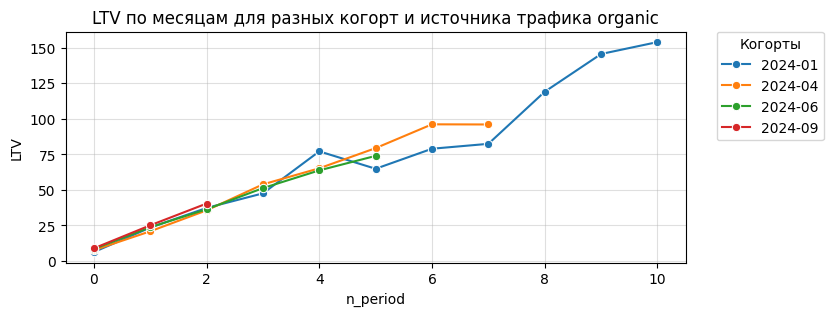

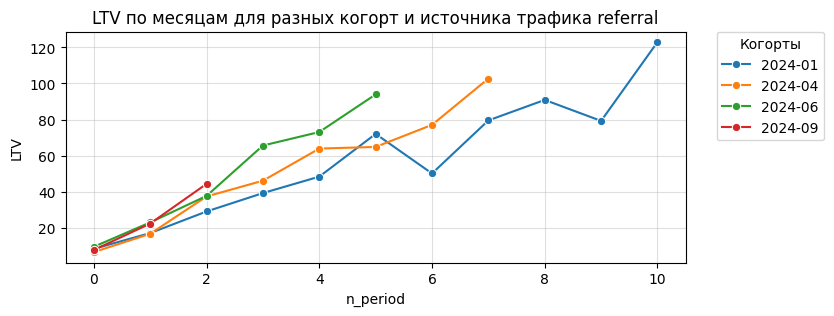

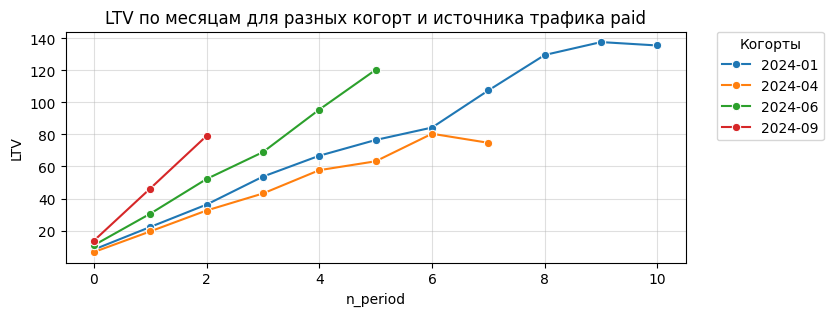

In [20]:
# Список источников трафика для визуализации
traffic_sources = ['organic', 'referral', 'paid']

# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (8, 3)

# Строим графики для каждого из трёх источников трафика в цикле
for traffic_source in traffic_sources:
    # Фильтруем данные только для текущего источника трафика
    filtered_data = df_plot[df_plot['traffic_type'] == traffic_source]

    # Строим линейный график
    sns.lineplot(data=filtered_data, x='n_period', y='LTV', hue='first_activity_month', marker='o')

    # Размещаем легенду справа от графика
    plt.legend(title='Когорты', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    # Устанавливаем заголовок
    plt.title(f'LTV по месяцам для разных когорт и источника трафика {traffic_source}')

    # Устанавливаем названия осей
    plt.xlabel('n_period')
    plt.ylabel('LTV')

    # Добавляем полупрозрачную сетку
    plt.grid(alpha=.4)
    plt.show()

Получили графики с динамикой LTV для четырёх когорт и трёх источников трафика.  
**Органический трафик** демонстрирует стабильный LTV без существенных изменений в динамике. Линейный график когорт первой и второй половины года показывает, что угол наклона LTV практически идентичен. Это подтверждает отсутствие значимых изменений в динамике показателя.  
**Для реферального трафика** заметны небольшие различия в динамике LTV между когортами первой и второй половины года. Линии когорт второй половины года слегка отклоняются от траектории ранних когорт, демонстрируя чуть более быстрый рост LTV, хотя разница не существенна.  
**Платный трафик** показывает наиболее выраженный рост LTV: когорты второй половины года значительно опережают показатели первой половины. На графике виден резкий рост угла наклона LTV для поздних когорт, что указывает на положительную динамику в монетизации платного трафика.

- **Визуализируем динамику LTV в разрезе двух источников трафика — `referral` и `paid`**. Построим две тепловые карты для анализа динамики LTV пользователей из разных когорт. Для этого воспользуемся датафреймом `df_grouped_ltv`.  

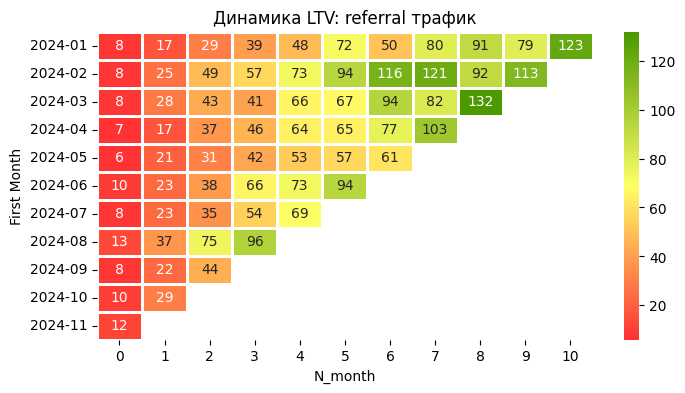

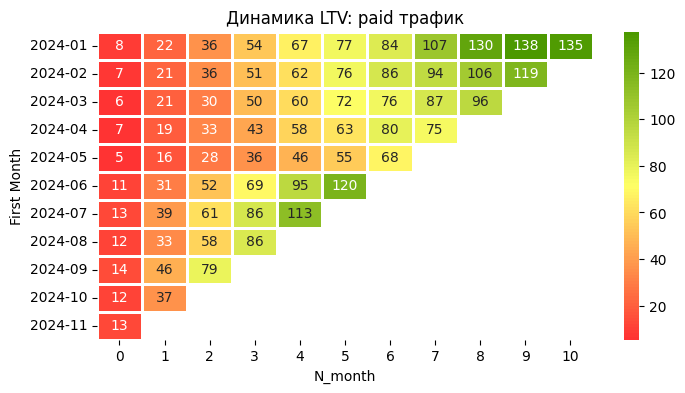

In [21]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (8, 4)

# Создаём pivot-таблицы для визуализации LTV по типам трафика:

# Для referral-трафик
df_pivot_referral = df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'referral'].pivot(index='first_activity_month', columns='n_period', values='LTV')
# Заменяем нули на Nan
df_pivot_referral[df_pivot_referral == 0] = float('nan')

# Для paid-трафика
df_pivot_paid = df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'paid'].pivot(index='first_activity_month', columns='n_period', values='LTV')
# Заменяем нули на Nan
df_pivot_paid[df_pivot_paid == 0] = float('nan')


# Строим тепловые карты:

# Строим тепловую карту для трафика referral
sns.heatmap(df_pivot_referral, annot=True, fmt='.0f', cmap=cmap, annot_kws={'size':10}, linewidths=2)

# Добавляем подписи для осей и заголовок графика referral
plt.title('Динамика LTV: referral трафик')
plt.xlabel('N_month')
plt.ylabel('First Month')
plt.show()

# Строим тепловую карту для трафика paid
sns.heatmap(df_pivot_paid, annot=True, fmt='.0f', cmap=cmap, annot_kws={'size':10},linewidths=2)


# Добавляем подписи для осей и заголовок графика paid
plt.title('Динамика LTV: paid трафик')
plt.xlabel('N_month')
plt.ylabel('First Month')
plt.show()

Начиная с июня наблюдается рост LTV для платного трафика

## Расчёт CAC

- **Визуализируем динамику затрат в разрезе источников трафика**

In [22]:
df_marketing_costs.head()

,month,source,traffic_type,marketing_costs
0,2024-01,google,paid,8269
1,2024-01,telegram,paid,6230
2,2024-01,partners_websites,paid,6876
3,2024-01,ref,referral,4363
4,2024-01,vk,paid,5085


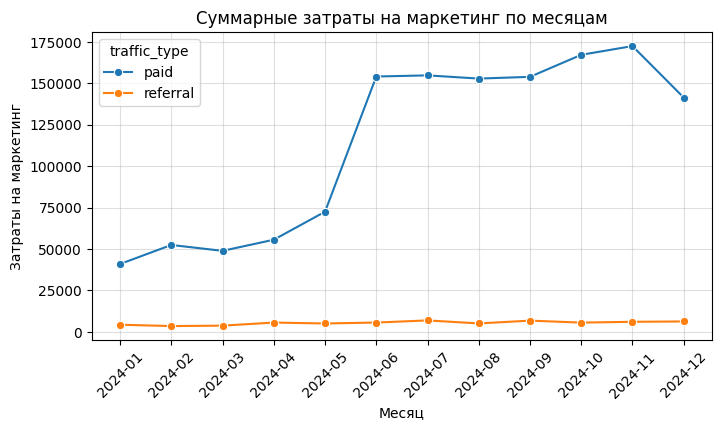

In [23]:
# Подготовим данные для визуализации: сгруппируем по месяцам и типу трафика и рассчитаем суммарные затраты
df_plot = df_marketing_costs.groupby(['month', 'traffic_type'])['marketing_costs'].sum().reset_index()

# Строим линейный график маркетинговых затрат для каждого типа трафика
sns.lineplot(
    data=df_plot,
    x='month',
    y='marketing_costs',
    hue='traffic_type',
    errorbar=('ci', False),
    marker='o'
)

# Оформляем график
plt.grid(alpha=.4)
plt.xticks(rotation=45)

# Добавляем подписи осей
plt.xlabel('Месяц')
plt.ylabel('Затраты на маркетинг')

# Добавляем заголовок
plt.title('Суммарные затраты на маркетинг по месяцам')
plt.show()

Начиная с июня суммарные маркетинговые затраты для привлечения пользователей из платного трафика существенно выросли примерно в 2,5 раза относительно первой половины года

- **Рассчитаем стоимость привлечения одного клиента САС** Воспользуемся подготовленным ранее датафреймом `df_monthly` с данными о событиях, транзакциях и источниках привлечения, а также датафреймом `df_marketing_costs` с данными о маркетинговых затратах.  
Для удобства в датафрейме `df_marketing_costs` предварительно создадим столбец `first_activity_month` в формате месяца `Period[M]`.  
Используя датафрейм `df_monthly` рассчитаем количество уникальных пользователей для каждой когорты, типа и источника трафика.  
Объединим маркетинговые затраты из `df_marketing_costs` с количеством поьзователей и рассчитаем САС. Почученное поле `САС` добавим в основной датафрейм `df_monthly`

In [24]:
# Преобразуем время события в формате месяца Period[M] для анализа данных по месяцам
df_marketing_costs['first_activity_month']  = pd.to_datetime(df_marketing_costs['month']).dt.to_period('M')
df_marketing_costs.head()

,month,source,traffic_type,marketing_costs,first_activity_month
0,2024-01,google,paid,8269,2024-01
1,2024-01,telegram,paid,6230,2024-01
2,2024-01,partners_websites,paid,6876,2024-01
3,2024-01,ref,referral,4363,2024-01
4,2024-01,vk,paid,5085,2024-01


In [25]:
# Определяем колонки для группировки: когорта, источник и тип трафика
gp_cols = ['first_activity_month', 'source', 'traffic_type']

In [26]:
# Считаем количество уникальных устройств (пользователей) для каждой комбинации: когорта + источник + тип трафика
df_clients_count = df_monthly.groupby(gp_cols)['device_id'].nunique().reset_index(name='uniq_devices')
df_clients_count.head()

,first_activity_month,source,traffic_type,uniq_devices
0,2024-01,direct_app_download,organic,454
1,2024-01,google,paid,107
2,2024-01,instagram,paid,100
3,2024-01,partners_websites,paid,99
4,2024-01,ref,referral,143


In [27]:
# Объединяем данные о маркетинговых затратах с количеством пользователей
df_CAC = df_marketing_costs.merge(df_clients_count, on=gp_cols, how='left')

In [28]:
# Рассчитываем стоимость привлечения клиента по формуле: CAC = расходы на маркетинг / количество привлечённых пользователей
df_CAC['CAC'] = df_CAC['marketing_costs'] / df_CAC['uniq_devices']
df_CAC.head()

,month,source,traffic_type,marketing_costs,first_activity_month,uniq_devices,CAC
0,2024-01,google,paid,8269,2024-01,107.0,77.280374
1,2024-01,telegram,paid,6230,2024-01,NaN,NaN
2,2024-01,partners_websites,paid,6876,2024-01,99.0,69.454545
3,2024-01,ref,referral,4363,2024-01,143.0,30.510490
4,2024-01,vk,paid,5085,2024-01,84.0,60.535714


In [29]:
# Добавляем колонку CAC в основной датафрейм
df_monthly = pd.merge(
    df_monthly, df_CAC[['first_activity_month', 'source', 'traffic_type','CAC']], on=gp_cols, how='left'
)

In [30]:
df_monthly.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue,traffic_type,source,n_period,LTV,CAC
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google,0,0.0,75.296296
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1,0.0,75.296296
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4,0.0,75.296296
3,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok,0,0.0,284.411765
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,2024-09,13,64.0,paid,tiktok,1,64.0,284.411765


Таким образом, для каждой когорты и каждого источника трафика рассчитано значение CAC. Полученные результаты позволят оценить, как менялась стоимость привлечения одного клиента из разных источников от когорты к когорте.

- **Визуализируем динамику среднего САС по типам трафика** Для этого сгруппируем данные датафрейма`df_monthly` по когортам и типу трафика и рассчитанм средний САС для каждой группы.

In [31]:
# Группируем данные по когорте (месяц первой активности) и типу трафика — рассчитываем средний CAC для каждой группы
cac_grouped = df_monthly.groupby(['first_activity_month', 'traffic_type'])['CAC'].mean().reset_index()

In [32]:
# Конвертируем first_activity_month в timestamp для корректной работы с осью времени
cac_grouped['first_activity_month'] = cac_grouped['first_activity_month'].dt.to_timestamp()

In [33]:
cac_grouped.head()

,first_activity_month,traffic_type,CAC
0,2024-01-01,organic,NaN
1,2024-01-01,paid,71.563727
2,2024-01-01,referral,30.510490
3,2024-02-01,organic,NaN
4,2024-02-01,paid,74.600856


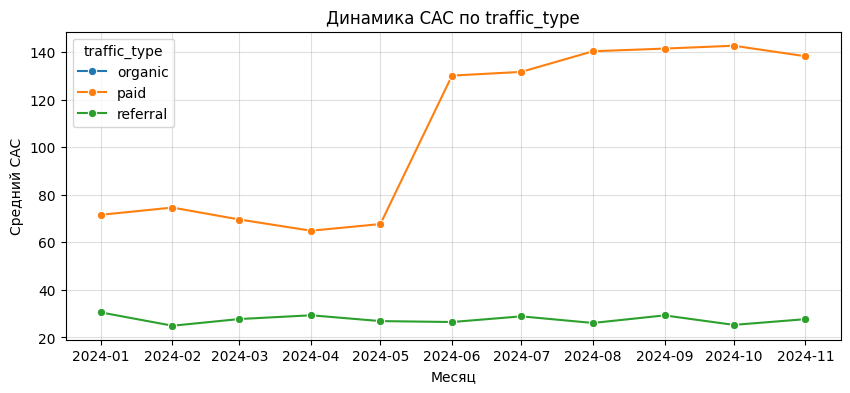

In [34]:
# Задаем размер для графика
plt.figure(figsize=(10, 4))

# Строим линейный график с разделением по типам трафика 'traffic_type'
sns.lineplot(
    data=cac_grouped,
    x='first_activity_month',
    y='CAC',
    hue='traffic_type',
    errorbar=('ci', False),
    marker='o'
)

# Настраиваем отображение подписей
plt.xticks()
plt.grid(alpha=.4)

# Добавляем подписи осей
plt.xlabel('Месяц')
plt.ylabel('Средний CAC')
# Добавляем заголовок
plt.title('Динамика CAC по traffic_type')


plt.show()

Стоимость привлечения пользователей для реферального трафика оставалась стабильной в течение года. А стоимость привлечения пользователя из платного трафика со второй половины года выросла более чем в полтора раза.

Анализ позволил выявить не только сильные стороны, но и скрытые недостатки текущей маркетинговой стратегии компании. Оказалось, что рост LTV платного трафика во второй половине года сопровождается значительным увеличением маркетинговых затрат и повышением стоимости привлечения одного клиента (CAC).  
Далее необходимо понять, оправданы ли такие затраты, то есть необходим анализ метрик Payback Period и ROI.

## Расчёт Payback Period

Определим, за какой период окупаются затраты, то есть когда суммарный доход от пользователя (LTV) становится равен затратам на его привлечение.

In [35]:
# Из основной таблицы выберем только значения для платного трафика
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']

# Для каждой когорты и канала посчитаем среднее значение LTV, CAC
cac_ltv_grouped = df_monthly_paid.groupby(['first_activity_month', 'n_period'])[['LTV', 'CAC']].mean().reset_index()

In [36]:
cac_ltv_grouped.head()

,first_activity_month,n_period,LTV,CAC
0,2024-01,0,8.131399,71.493827
1,2024-01,1,22.216867,71.649327
2,2024-01,2,36.205955,71.732369
3,2024-01,3,53.670918,71.294831
4,2024-01,4,66.690176,71.619551


Вспомогательный датафрейм готов

- **Визуализируем изменением LTV и CAC для когорт пользователей, привлеченных через платный трафик**

In [37]:
# Создадим словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}

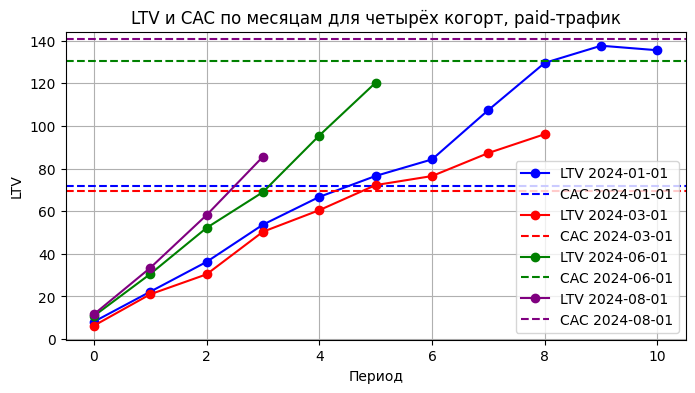

In [38]:
# Задаем размеры графика
plt.figure(figsize=(8, 4))

# Строим линии для каждого значения  first_activity_month
for month, color in first_months_colors.items():
    # Создаём отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month ]

    # Строим LTV с цветом из словаря
    plt.plot(df_plot['n_period'], df_plot['LTV'], color=color, marker='o', label=f'LTV {month}')

    # Строим линию для CAC с таким же цветом
    cac_value = df_plot['CAC'].mean()
    plt.axhline(y=cac_value, color=color, linestyle='--', label=f'CAC {month}')


# Добавляем заголовок
plt.title('LTV и CAC по месяцам для четырёх когорт, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('LTV')

# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid()
plt.show()

Графики подтверждают, что для когорт второй половины года наблюдается ускоренный рост LTV, при этом значительно выросла и стоимость привлечения CAC.  

Если мысленно продлить линии LTV, то отличия в Payback Period у когорт первой и второй половины года окажутся довольно незначительными и, скорее всего, не превысят одного месяца - их Payback Period будет находиться в промежутке от четырёх с половиной до пяти с половиной месяцев.  

Визуальный анализ позволяет сделать важное наблюдение: у когорт второй половины года период окупаемости незначительно увеличивается, что вполне закономерно, учитывая рост маркетинговых затрат в этот период. Для получения полной картины необходимо оценить показатель окупаемости инвестиций.

## Расчёт ROI

Чтобы окончательно оценить эффективность маркетингового бюджета, рассчитаем и визуализируем окупаемость инвестиций — метрику ROI, чтобы наглядно оценить динамику возврата инвестиций для некоторых когорт первой и второй половины года. 

- **Визуализируем динамику ROI для когорт пользователей и границу окупаемости затрат.** 

In [39]:
# Рассчитываем ROI для каждой когорты и периода
cac_ltv_grouped['ROI'] = (cac_ltv_grouped['LTV'] - cac_ltv_grouped['CAC']) / cac_ltv_grouped['CAC'] * 100

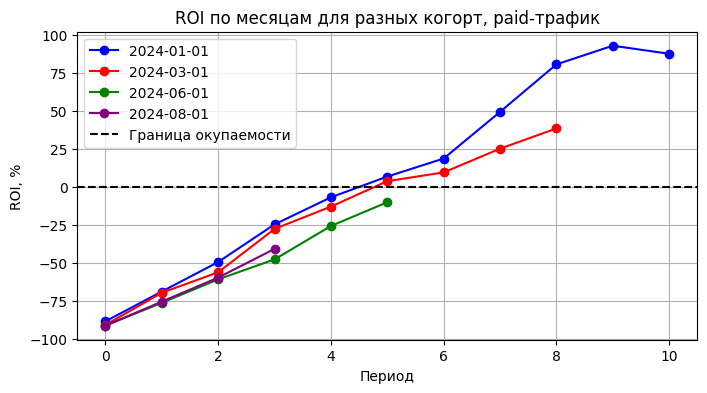

In [40]:
# Создаём график
plt.figure(figsize=(8, 4))

# Строим линии для каждого first_activity_month
for month, color in first_months_colors.items():
    # Создаём промежуточный отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]

    # Строим динамику ROI по периодам с цветами из словаря
    plt.plot(df_plot['n_period'], df_plot['ROI'], marker='o', label=month, color=color)

# Добавляем горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости)

# Добавляем заголовок
plt.title('ROI по месяцам для разных когорт, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('ROI, %')
# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid()
plt.show()

ROI платного трафика у когорт первой и второй половины года демонстрирует незначительные различия без существенных изменений в динамике.

- **Создадим тепловую карту для анализа ROI в разрезе всех когорт и периодов.**

In [41]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

In [42]:
# Пивотируем данные:
# pivot для LTV
df_pivot_ltv = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='LTV')
df_pivot_ltv[df_pivot_ltv == 0] = float('nan')
df_pivot_ltv

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,8.131399,22.216867,36.205955,53.670918,66.690176,76.528024,84.283988,107.456929,129.579167,137.623037,135.496774
2024-02,7.412766,21.296959,35.731602,51.141280,62.134703,76.122500,86.476427,94.477816,105.867347,118.843602,NaN
2024-03,6.259797,21.001792,30.376050,50.348519,60.468410,72.242424,76.473282,87.287879,96.122302,NaN,NaN
2024-04,6.564014,19.455556,32.514530,43.131034,57.681818,63.230928,80.418033,74.756563,NaN,NaN,NaN
2024-05,5.395480,16.322132,28.443983,36.320644,46.459138,54.821018,67.805842,NaN,NaN,NaN,NaN
2024-06,10.812500,30.509276,52.165563,68.949250,95.497076,120.295720,NaN,NaN,NaN,NaN,NaN
2024-07,13.239198,39.003742,61.209276,86.095794,113.374854,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,11.599324,33.382022,58.163569,85.565380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,13.636134,46.215481,79.058473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# pivot для CAC
df_pivot_cac = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='CAC')
df_pivot_cac[df_pivot_cac == 0] = float('nan')
df_pivot_cac

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,71.493827,71.649327,71.732369,71.294831,71.619551,71.653553,71.017066,71.907681,71.687850,71.286141,72.165557
2024-02,74.606112,74.520679,74.544883,74.694436,74.646159,74.650782,74.630216,74.510310,74.570147,74.643320,NaN
2024-03,69.500894,69.517451,69.500322,69.650867,69.499165,69.621843,69.810981,69.728881,69.391955,NaN,NaN
2024-04,64.863201,64.846449,64.882574,64.893120,64.820751,64.946072,64.828030,64.852383,NaN,NaN,NaN
2024-05,67.657534,67.592745,67.808476,67.613502,67.671115,67.590450,67.740102,NaN,NaN,NaN,NaN
2024-06,125.644188,129.346688,133.542574,132.125766,128.661568,133.853392,NaN,NaN,NaN,NaN,NaN
2024-07,127.445423,130.103351,134.731559,134.419234,134.015735,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,137.000956,137.087807,144.704601,144.737122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,138.716746,141.614295,145.147310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Расчёт матрицы ROI на основе пивотированных таблиц LTV и CAC
df_pivot_roi = (df_pivot_ltv - df_pivot_cac) / df_pivot_cac * 100

# Заменяем нули в df_pivot_roi на NaN для корректной отрисовки
df_pivot_roi[df_pivot_roi == 0] = float('nan')

df_pivot_roi

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,-88.626432,-68.992217,-49.526336,-24.719762,-6.882722,6.802832,18.681315,49.437345,80.754713,93.057213,87.758232
2024-02,-90.064130,-71.421411,-52.066996,-31.532677,-16.761017,1.971470,15.873210,26.798312,41.970146,59.215321,NaN
2024-03,-90.993214,-69.789180,-56.293655,-27.713004,-12.994049,3.764022,9.543343,25.181814,38.520815,NaN,NaN
2024-04,-89.880219,-69.997501,-49.887115,-33.535273,-11.013345,-2.640874,24.048243,15.271884,NaN,NaN,NaN
2024-05,-92.025308,-75.852243,-58.052466,-46.281966,-31.345688,-18.892361,0.097047,NaN,NaN,NaN,NaN
2024-06,-91.394349,-76.412789,-60.937129,-47.815439,-25.776533,-10.128747,NaN,NaN,NaN,NaN,NaN
2024-07,-89.611869,-70.020955,-54.569459,-35.949796,-15.401834,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,-91.533399,-75.649167,-59.805308,-40.882216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,-90.169799,-67.365243,-45.532251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


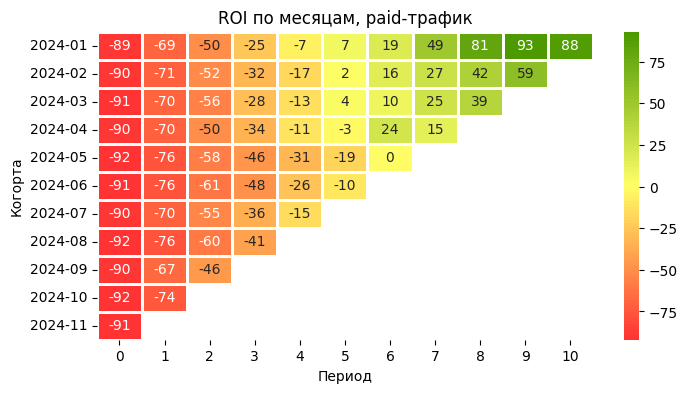

In [45]:
# Создаём график
plt.figure(figsize=(8, 4))

# Строим heatmap
sns.heatmap(df_pivot_roi, cmap=cmap, annot=True, fmt='.0f', annot_kws={'size':10}, linewidths=2)

# Добавляем заголовок
plt.title('ROI по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

Тепловая карта не показывает резких отклонений у когорт первой и второй половины года. Значит, существенных изменений нет. 
Майская когорта достигла порога окупаемости позже предыдущих. Ускоренный рост LTV компенсировал увеличение CAC, что привело к отсутствию заметных колебаний ROI на графиках.

## Расчёт ARPPU и Retention Rate

Чтобы углубить анализ, добавим два ключевых показателя: Average Revenue per Paying User и Retention Rate, которые позволят получить полную картину экономической эффективности приложения

- **Рассчитаем и визуализируем ARPPU**. Эта метрика позволит понять, насколько эффективно монетизируются платящие пользователи приложения.

In [46]:
# фильтруем датафрейм и учитываем только пользователей с платного трафика
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']
df_monthly_paid.head()

,device_id,activity_month,first_activity_month,count_sessions,total_revenue,traffic_type,source,n_period,LTV,CAC
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-07,2024-07,9,0.0,paid,google,0,0.0,75.296296
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1,0.0,75.296296
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4,0.0,75.296296
3,00010045-a5c6-4428-a40e-543f6a00c779,2024-09,2024-09,10,0.0,paid,tiktok,0,0.0,284.411765
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,2024-09,13,64.0,paid,tiktok,1,64.0,284.411765


In [47]:
df_revenue = df_monthly_paid.groupby(['first_activity_month', 'n_period'])['total_revenue'].sum().reset_index()

In [48]:
# pivot для суммарной выручки по когортам и периодам
df_pivot_sum_revenue = df_revenue.pivot(index='first_activity_month', columns='n_period', values='total_revenue')

df_pivot_sum_revenue

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,4765.0,7002.0,6185.0,7035.0,6896.0,5241.0,6690.0,6869.0,4381.0,4177.0,4095.0
2024-02,5226.0,7410.0,7435.0,8693.0,8068.0,7331.0,8130.0,5705.0,5902.0,4669.0,NaN
2024-03,4313.0,7846.0,6006.0,8419.0,7676.0,7265.0,5474.0,5081.0,4102.0,NaN,NaN
2024-04,5691.0,9322.0,8346.0,8619.0,9265.0,7478.0,8728.0,5530.0,NaN,NaN,NaN
2024-05,5730.0,9094.0,9693.0,8696.0,10916.0,9590.0,9707.0,NaN,NaN,NaN,NaN
2024-06,14186.0,20452.0,21379.0,22857.0,26999.0,24579.0,NaN,NaN,NaN,NaN,NaN
2024-07,17158.0,27507.0,22368.0,24385.0,26361.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,13722.0,21090.0,23187.0,25395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,16227.0,29625.0,31409.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# оставляем только платящих пользователей и считаем количество уникальных 
df_paying_users = df_monthly_paid[df_monthly_paid['total_revenue'] > 0].groupby(['first_activity_month', 'n_period'])['device_id'].nunique().reset_index()

In [50]:
# pivot для количества платящих пользователей (уникальные device_id с revenue > 0)
df_pivot_paying_users = df_paying_users.pivot(index='first_activity_month', columns='n_period', values='device_id')
df_pivot_paying_users

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,81.0,111.0,97.0,98.0,105.0,92.0,100.0,80.0,72.0,71.0,56.0
2024-02,101.0,122.0,112.0,115.0,112.0,114.0,124.0,82.0,83.0,69.0,NaN
2024-03,86.0,118.0,113.0,125.0,121.0,107.0,99.0,90.0,72.0,NaN,NaN
2024-04,113.0,150.0,149.0,155.0,155.0,125.0,130.0,114.0,NaN,NaN,NaN
2024-05,122.0,175.0,148.0,169.0,173.0,164.0,164.0,NaN,NaN,NaN,NaN
2024-06,224.0,271.0,275.0,264.0,299.0,291.0,NaN,NaN,NaN,NaN,NaN
2024-07,234.0,305.0,273.0,265.0,301.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,189.0,262.0,277.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,248.0,302.0,313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Рассчитываем ARPPU и очищаем данные
df_pivot_arppu = df_pivot_sum_revenue / df_pivot_paying_users
df_pivot_arppu[df_pivot_arppu == 0] = float('nan')
df_pivot_arppu

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,58.827160,63.081081,63.762887,71.785714,65.676190,56.967391,66.900000,85.862500,60.847222,58.830986,73.125
2024-02,51.742574,60.737705,66.383929,75.591304,72.035714,64.307018,65.564516,69.573171,71.108434,67.666667,NaN
2024-03,50.151163,66.491525,53.150442,67.352000,63.438017,67.897196,55.292929,56.455556,56.972222,NaN,NaN
2024-04,50.362832,62.146667,56.013423,55.606452,59.774194,59.824000,67.138462,48.508772,NaN,NaN,NaN
2024-05,46.967213,51.965714,65.493243,51.455621,63.098266,58.475610,59.189024,NaN,NaN,NaN,NaN
2024-06,63.330357,75.468635,77.741818,86.579545,90.297659,84.463918,NaN,NaN,NaN,NaN,NaN
2024-07,73.324786,90.186885,81.934066,92.018868,87.578073,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,72.603175,80.496183,83.707581,84.933110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,65.431452,98.096026,100.348243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


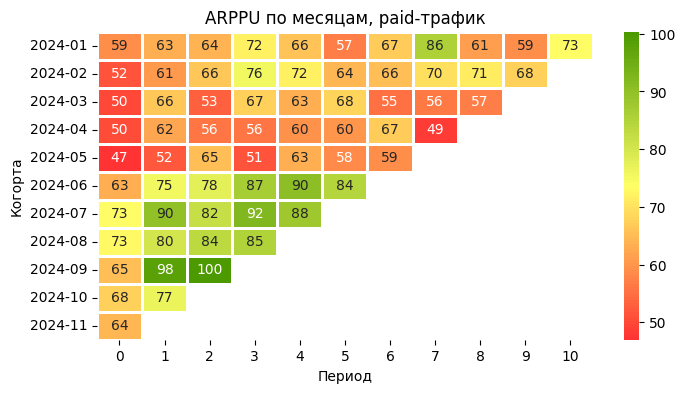

In [52]:
# Создаём график
plt.figure(figsize=(8, 4))

# Строим heatmap ARPPU
sns.heatmap(df_pivot_arppu, cmap=cmap, annot=True, fmt='.0f', annot_kws={'size':10}, linewidths=2)

# Добавляем заголовок
plt.title('ARPPU по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

Наблюдается рост ARPPU для когорт второй половины года.

- **Рассчитаем и визуализируем Retention Rate**

In [53]:
# Создаём сводную таблицу активных пользователей из платного трафика
df_active_users = df_monthly_paid.groupby(['first_activity_month', 'n_period'])['device_id'].nunique().reset_index()
df_pivot_active_users = df_active_users.pivot(index='first_activity_month', columns='n_period', values='device_id')
df_pivot_active_users

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,586.0,498.0,403.0,392.0,397.0,339.0,331.0,267.0,240.0,191.0,155.0
2024-02,705.0,559.0,462.0,453.0,438.0,400.0,403.0,293.0,294.0,211.0,NaN
2024-03,689.0,558.0,476.0,439.0,459.0,363.0,393.0,330.0,278.0,NaN,NaN
2024-04,867.0,720.0,585.0,580.0,572.0,485.0,488.0,419.0,NaN,NaN,NaN
2024-05,1062.0,863.0,723.0,683.0,673.0,609.0,582.0,NaN,NaN,NaN,NaN
2024-06,1312.0,1078.0,906.0,867.0,855.0,771.0,NaN,NaN,NaN,NaN,NaN
2024-07,1296.0,1069.0,884.0,856.0,859.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,1183.0,979.0,807.0,803.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,1190.0,956.0,838.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Рассчитываем Retention Rate (%)
df_pivot_retention = df_pivot_active_users.apply(lambda row: row * 100 /row[0], axis=1)
df_pivot_retention[df_pivot_retention == 0] = float('nan')
df_pivot_retention

n_period,0,1,2,3,4,5,6,7,8,9,10
first_activity_month,,,,,,,,,,,
2024-01,100.0,84.982935,68.771331,66.894198,67.747440,57.849829,56.484642,45.563140,40.955631,32.593857,26.450512
2024-02,100.0,79.290780,65.531915,64.255319,62.127660,56.737589,57.163121,41.560284,41.702128,29.929078,NaN
2024-03,100.0,80.986938,69.085631,63.715530,66.618287,52.685051,57.039187,47.895501,40.348331,NaN,NaN
2024-04,100.0,83.044983,67.474048,66.897347,65.974625,55.940023,56.286044,48.327566,NaN,NaN,NaN
2024-05,100.0,81.261770,68.079096,64.312618,63.370998,57.344633,54.802260,NaN,NaN,NaN,NaN
2024-06,100.0,82.164634,69.054878,66.082317,65.167683,58.765244,NaN,NaN,NaN,NaN,NaN
2024-07,100.0,82.484568,68.209877,66.049383,66.280864,NaN,NaN,NaN,NaN,NaN,NaN
2024-08,100.0,82.755706,68.216399,67.878276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09,100.0,80.336134,70.420168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


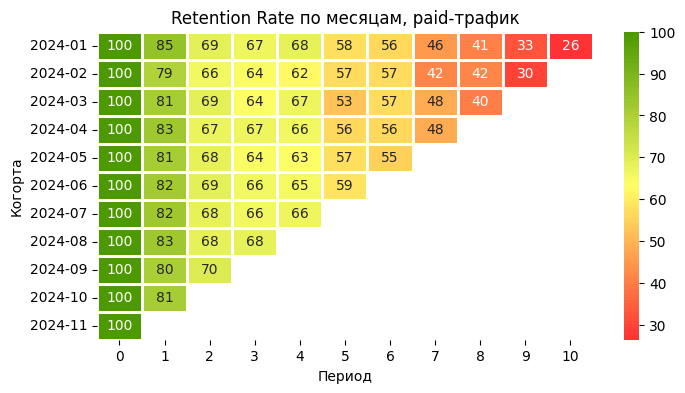

In [55]:
# Создаём график
plt.figure(figsize=(8, 4))

# Строим heatmap Retention Rate
sns.heatmap(df_pivot_retention, cmap=cmap, annot=True, fmt='.0f', annot_kws={'size':10}, linewidths=2)

# Добавляем заголовок
plt.title('Retention Rate по месяцам, paid-трафик')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()